<a href="https://colab.research.google.com/github/gcunharodrigues/desafio-dio/blob/main/desafio_dio_deteccao_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

import keras
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [20]:
def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return faces

In [21]:
# Função de pré-processamento
def preprocess_image(label, image):
    image = tf.image.resize(image, [224, 224])  # Redimensionar
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar (0 a 1)

    label = table.lookup(label)  # Map string label to integer
    return image, tf.cast(label, tf.int32)

In [22]:
builder = 'lfw'

ds = tfds.load(builder, split='train', as_supervised=True)

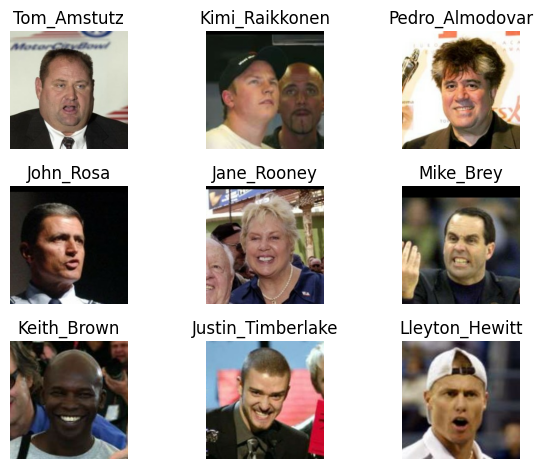

In [23]:
for i, (label, image) in enumerate(ds.take(9)):
  label = label.numpy().decode('utf-8')
  #image = tensor[1].numpy()
  plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
labels = [l.numpy().decode('utf-8') for l, _ in ds]
unique_labels = list(set(labels))

num_classes = len(unique_labels)

In [25]:
for l,i in ds.take(2):
  print(l.numpy().decode('utf_8'),i.shape)

Tom_Amstutz (250, 250, 3)
Kimi_Raikkonen (250, 250, 3)


In [49]:
# Create a TensorFlow lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(unique_labels),
        values=tf.constant(list(range(len(unique_labels)))),
    ),
    default_value=-1  # Default value if key is not found
)

# Create the reverse lookup table (integer to string)
reverse_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(range(len(unique_labels)))),  # Integers as keys
        values=tf.constant(unique_labels),                 # Labels as values
    ),
    default_value="unknown"  # Default value if integer is not found
)

In [27]:
ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Modelo base para transfer learning
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas de saída
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Define split proportions
VALIDATION_SPLIT = 0.0  # 20% validation
TRAIN_SPLIT = 1.0 - VALIDATION_SPLIT

# Compute sizes
total_size = tf.data.experimental.cardinality(ds).numpy()
train_size = int(TRAIN_SPLIT * total_size)
val_size = total_size - train_size

# Split into train and validation
train_dataset = ds.take(train_size)
validation_dataset = ds.skip(train_size)

# Batch dataset
train_dataset = train_dataset.batch(1).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

# Model training
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=10)

Epoch 1/10
13233/13233 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - accuracy: 0.0400 - loss: 8.4453
Epoch 2/10
13233/13233 ━━━━━━━━━━━━━━━━━━━━ 120s 9ms/step - accuracy: 0.0421 - loss: 7.8111
Epoch 3/10
13233/13233 ━━━━━━━━━━━━━━━━━━━━ 119s 9ms/step - accuracy: 0.0456 - loss: 7.9069
Epoch 4/10
13233/13233 ━━━━━━━━━━━━━━━━━━━━ 119s 9ms/step - accuracy: 0.0468 - loss: 7.9910
Epoch 5/10
13233/13233 ━━━━━━━━━━━━━━━━━━━━ 120s 9ms/step - accuracy: 0.0469 - loss: 7.9948
Epoch 6/10
13233/13233 ━━━━━━━━━━━━━━━━━━━━ 119s 9ms/step - accuracy: 0.0471 - loss: 8.0791
Epoch 7/10
 3294/13233 ━━━━━━━━━━━━━━━━━━━━ 1:30 9ms/step - accuracy: 0.0520 - loss: 7.8566

In [1]:
# Load the image from disk
image_path = "wi_ke.jpg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error: Unable to load the image.")
else:
    print("Image loaded successfully!")

NameError: name 'cv2' is not defined

In [73]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert the image to grayscale (required for Haar Cascade)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

print(f"Number of faces detected: {len(faces)}")

Number of faces detected: 2


In [74]:
face_images = []
for (x, y, w, h) in faces:  # For Haar Cascade
    # Crop the face from the image
    face = image[y:y+h, x:x+w]

    # Resize to match model input shape (e.g., 224x224 for MobileNet)
    face_resized = cv2.resize(face, (224, 224)) / 255.0  # Normalize pixel values to [0, 1]

    # Add batch dimension (required for model prediction)
    face_resized = np.expand_dims(face_resized, axis=0)

    face_images.append(face_resized)

In [83]:
for face in face_images:
    predictions = model.predict(face)

    # Get the class with the highest confidence
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    print(f"Predicted Class: {predicted_class}, Confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Class: 5050, Confidence: 0.9959442019462585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class: 1897, Confidence: 0.6104494333267212


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


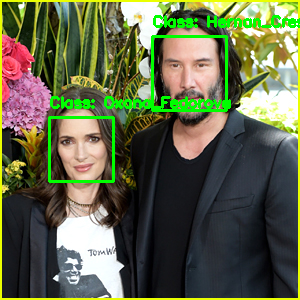

In [84]:
from google.colab.patches import cv2_imshow
for i, (x, y, w, h) in enumerate(faces):
    predicted_class = np.argmax(model.predict(face_images[i])[0])
    predicted_class = reverse_table.lookup(tf.constant([predicted_class]))[0].numpy().decode('utf-8')

    # Draw bounding box
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Add label
    cv2.putText(image, f"Class: {predicted_class}", (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the annotated image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()